# 作业: 逻辑回归

## 作业要求：

用numpy实现Logistic Regression类（补充cell 1中定义的LogisticRegression类），用梯度下降法训练

1. 包括类的方法 loss = fit(X,Y) 函数，用于训练；输入：X为N * d维的训练数据，N为训练样本数，d为数据的维数；Y为N*1维的训练数据真实类别号；输出：loss为列表，包括每轮的损失函数值。

2. 包括类的方法 y_pred, y_pred_label = predict(X) 函数，用于测试；输入： X为N * d维的测试数据， N为测试样本数；输出：y_pred维数为N * 1，为模型的预测（回归）值；y_pred_label维数为N * 1，为根据回归值得到的预测类别号

In [1]:
#人工数据生成、训练测试数据划分、可视化，请勿修改本cell代码
import matplotlib.pyplot as plt

def generateData(opt='linear', num_perclass = 100, seed = 1):
    np.random.seed(seed)
    # 正负样本个数
    m_pos = num_perclass;
    m_neg = num_perclass;
    X = np.zeros((2,m_pos+m_neg))
    Y = np.zeros((1,m_pos+m_neg))

    # 分布类型：环形、线性函数
    if opt=='circle':  
        R1_range = 10
        R2_range = 5
        R_pos = R1_range*np.random.rand(1,m_pos)
        R_neg = R2_range*np.random.rand(1,m_neg)+0.9*R1_range
        Theta_pos = np.pi*np.random.randn(1,m_pos)
        Theta_neg = np.pi*np.random.randn(1,m_neg)

        X[0:1,0:m_pos]=R_pos*np.cos(Theta_pos);
        X[1:2,0:m_pos]=R_pos*np.sin(Theta_pos);
        Y[0,0:m_pos]=1;

        X[0:1,-m_neg:]=R_neg*np.cos(Theta_neg);
        X[1:2,-m_neg:]=R_neg*np.sin(Theta_neg);
        Y[0,-m_neg:]=0;

    if opt=='linear':        
        x1 = np.random.normal(loc=-1,scale=3,size=(1,m_pos))
        X[0:1,0:m_pos] = x1;
        # 整体线性分布
        X[1:2,0:m_pos] = 2*x1+10+0.1*x1**2;
        # 加噪声
        X[1:2,0:m_pos] += np.random.normal(loc=0,scale=5,size=(1,m_pos));
        Y[0,0:m_pos] = 1;

        x1 = np.random.normal(loc=1,scale=3,size=(1,m_neg))
        X[0:1,-m_neg:] = x1;
        X[1:2,-m_neg:] = 2*x1-5-0.1*x1**2
        X[1:2,-m_neg:] += np.random.normal(loc=0,scale=5,size=(1,m_neg))

    return X.T,Y.T

def featureNormalize(X):
    mu = np.mean(X,axis=0,keepdims=True)
    sigma = np.std(X,axis=0,keepdims=True)
    X_norm = (X-mu)/sigma
    return mu,sigma,X_norm

def plotData(X,Y):
    plt.figure()
    pos_idx = (Y==1);
    # size m,1
    pos_idx = pos_idx[:,0];
    # size m, 这时才可用来索引某[一]个维度
    neg_idx = (Y==0);
    neg_idx = neg_idx[:,0];

    plt.plot(X[pos_idx,0],X[pos_idx,1],'r+')
    plt.plot(X[neg_idx,0],X[neg_idx,1],'bo')
    
def plotDecisioinBoundary(X,Y,mu,sigma,regr):    
    plotData(X,Y)

    plot_num=50;
    plot_num_2D=plot_num**2;

    x_plot = np.linspace(start=X[:,0].min(),stop=X[:,0].max(),num=plot_num)
    y_plot = np.linspace(start=X[:,1].min(),stop=X[:,1].max(),num=plot_num)
    X_plot,Y_plot = np.meshgrid(x_plot,y_plot)

    X_array = np.zeros((plot_num_2D,2))
    X_array[:,0:1] = X_plot.reshape(plot_num_2D,1)
    X_array[:,1:2] = Y_plot.reshape(plot_num_2D,1)

    X_norm = (X_array-mu)/sigma  #polyFeature(X_array,p)

    p_array,_ = regr.predict(X_norm)
    P_matrix = p_array.reshape((plot_num,plot_num))

    plt.contour(X_plot,Y_plot,P_matrix,np.array([0.5]))
    
def test(y_pred, y_true):
    true = 0.
    for j in range(y_pred.shape[0]):
        if y_true[j] == y_pred[j]:
            true += 1
    acc = true/y_pred.shape[0]
    return acc

In [2]:
import numpy as np

class LogisticRegression(object):
    def __init__(self, dim,learning_rate=0.01, max_iter=100, seed=None):
        np.random.seed(seed)
        self.lr = learning_rate
        self.max_iter = max_iter  # 定义学习率和训练轮数
        # 可在此处补充类的属性
        self.W=np.random.normal(loc=0.1,scale=1,size=(dim+1,1))
        self.loss_arr=[]
        
    def fit(self,X,Y_true):
        # 请在此处补充类的方法：训练函数，返回每轮loss的列表
        X= np.hstack([X, np.ones((X.shape[0], 1))])
        for i in range(self.max_iter):
            self.loss_function(X,Y_true)
            self.train_step(X,Y_true)
        return self.loss_arr
          
    def predict(self, X):
        # 请在此处补充类的方法：测试函数，返回对应X的预测值和预测类别列表
        if X.shape[1]!=dim+1:
            X= np.hstack([X, np.ones((X.shape[0], 1))])
        g_x=np.dot(X,self.W)
        h_x=1/(1+np.exp(-g_x))
        Y_pred=h_x
        Y_pred_label=np.where(h_x<0.5,0,1)
        return Y_pred, Y_pred_label
    
    def loss_function(self,X,Y_true):
        Y_pred,Y_pred_label=self.predict(X)
        cross_entroy_error= -np.mean(Y_true*np.log(Y_pred)+(1-Y_true)*np.log(1-Y_pred))
        self.loss_arr.append(cross_entroy_error)
        
        
    def cal_gradient(self,X,Y_true):
        Y_pred,Y_pred_label=self.predict(X)
#         dw=np.mean(X*(Y_pred-Y_true))
        dw=np.dot(X.T,(Y_pred-Y_true))/len(X)
        return dw
    
    def train_step(self,X,Y_true):
        
        dw=self.cal_gradient(X,Y_true)
        self.W=self.W-self.lr*dw
        

[[-0.88537625]
 [ 1.12587747]
 [-0.26757119]]


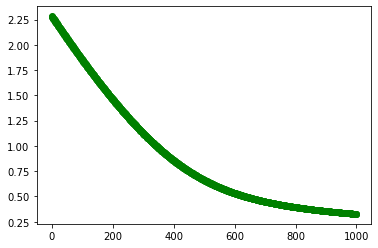

训练集上正确率:0.85


<Figure size 432x288 with 0 Axes>

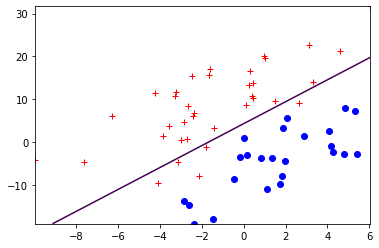

In [3]:
# 第一组测试
dim = 2
num_perclass = 100
seed = 210404
x,y = generateData(opt='linear', num_perclass = num_perclass, seed = seed)
shuffled_index = np.random.permutation(num_perclass*2)
x = x[shuffled_index,:]
y = y[shuffled_index,:]
split_index = int(2* num_perclass * 0.7)
x_train = x[:split_index,:]
y_train = y[:split_index,:]
x_test = x[split_index:,:]
y_test = y[split_index:,:]
mu,sigma,x_train_norm = featureNormalize(x_train)
x_test_norm = (x_test-mu)/sigma

# 训练逻辑回归模型
regr = LogisticRegression(dim, learning_rate=0.01, max_iter=1000, seed=seed)
loss = regr.fit(x_train_norm, y_train)
print(regr.W)
# 打印损失
plt.figure()
plt.scatter(np.arange(len(loss)), loss, marker='o', c='green')
plt.show()

# 显示测试集中的分类界面
plt.figure()
plotDecisioinBoundary(x_test,y_test,mu,sigma,regr)

y_pred,y_pred_label = regr.predict(x_test)
acc = test(y_pred_label, y_test)
print('训练集上正确率:{}'.format(acc))

[[-0.31060183]
 [-2.5291407 ]
 [-0.56564323]]


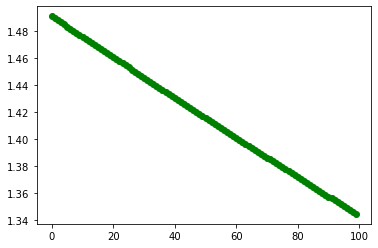

训练集上正确率:0.4666666666666667


<Figure size 432x288 with 0 Axes>

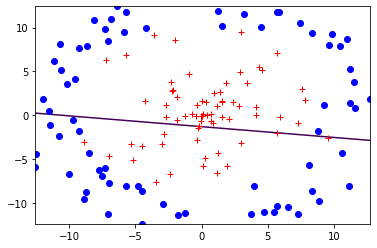

<Figure size 432x288 with 0 Axes>

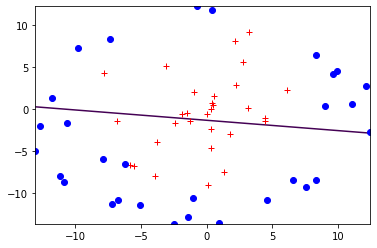

In [4]:
# 第二组测试
dim = 2
num_perclass = 100
seed = 210404
x,y = generateData(opt='circle', num_perclass = num_perclass, seed = seed)
shuffled_index = np.random.permutation(num_perclass*2)
x = x[shuffled_index,:]
y = y[shuffled_index,:]
split_index = int(2* num_perclass * 0.7)
x_train = x[:split_index,:]
y_train = y[:split_index,:]
x_test = x[split_index:,:]
y_test = y[split_index:,:]
mu,sigma,x_train_norm = featureNormalize(x_train)
x_test_norm = (x_test-mu)/sigma

# 训练逻辑回归模型
regr = LogisticRegression(dim, learning_rate=0.01, max_iter=100, seed=seed)
loss = regr.fit(x_train_norm, y_train)
print(regr.W)
# 打印损失
plt.figure()
plt.scatter(np.arange(len(loss)), loss, marker='o', c='green')
plt.show()

# 显示训练集和测试中的分类界面
plt.figure()
plotDecisioinBoundary(x_train,y_train,mu,sigma,regr)
plt.figure()
plotDecisioinBoundary(x_test,y_test,mu,sigma,regr)

y_pred,y_pred_label = regr.predict(x_test)
acc = test(y_pred_label, y_test)
print('训练集上正确率:{}'.format(acc))